#  Machine Learning을 활용한 Credit Card Default 예측

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import korean

### Dataset 구성
- limit_bal : credit 카드 한도  
- payment_status_{month}: 이전 6개월 중 해당 월의 payment status  
- bill_statement_{month}: 이전 6개월 중 해당 월의 청구 금액  
- previous_payment_{month} : 이전 6개월 중 해당 월의 결제 금액  
- default_payment_next_month : 익월 연체 여부 (1, 0)

In [2]:
df = pd.read_csv('data/credit_card_default.csv', index_col=0, na_values='')
print(df.shape)
df.head()

(30000, 24)


,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,...,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,20000,Female,University,Married,24.0,Payment delayed 2 months,Payment delayed 2 months,Payed duly,Payed duly,Unknown,...,0,0,0,0,689,0,0,0,0,1
1,120000,Female,University,Single,26.0,Payed duly,Payment delayed 2 months,Unknown,Unknown,Unknown,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,Female,University,Single,34.0,Unknown,Unknown,Unknown,Unknown,Unknown,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,Female,University,Married,37.0,Unknown,Unknown,Unknown,Unknown,Unknown,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,Male,University,Married,57.0,Payed duly,Unknown,Payed duly,Unknown,Unknown,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


- missing value check

In [3]:
df.isnull().sum()

limit_bal                       0
sex                           150
education                     150
marriage                      150
age                           150
payment_status_sep              0
payment_status_aug              0
payment_status_jul              0
payment_status_jun              0
payment_status_may              0
payment_status_apr              0
bill_statement_sep              0
bill_statement_aug              0
bill_statement_jul              0
bill_statement_jun              0
bill_statement_may              0
bill_statement_apr              0
previous_payment_sep            0
previous_payment_aug            0
previous_payment_jul            0
previous_payment_jun            0
previous_payment_may            0
previous_payment_apr            0
default_payment_next_month      0
dtype: int64

### Target 변수의 분포
- 신용카드 연체 가능성을 예측하는 것이므로, target 은 `default_payment_next_month` column 입니다.

In [4]:
df['default_payment_next_month'].value_counts()

0    23364
1     6636
Name: default_payment_next_month, dtype: int64

## Dealing with missing values

- `age`는 median 으로 채운다

In [5]:
df['age'].fillna(df['age'].median(), inplace=True)

- categorical feature('sex', 'education', 'marriage')는 sklearn 의 SimpleImputer를 이용하여 filling

In [6]:
from sklearn.impute import SimpleImputer

CAT_FEATURES = ['sex', 'education', 'marriage']

for col in CAT_FEATURES:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    cat_imputer.fit(df[[col]])
    df.loc[:, col] = cat_imputer.transform(df[[col]])

In [7]:
df.isnull().sum()

limit_bal                     0
sex                           0
education                     0
marriage                      0
age                           0
payment_status_sep            0
payment_status_aug            0
payment_status_jul            0
payment_status_jun            0
payment_status_may            0
payment_status_apr            0
bill_statement_sep            0
bill_statement_aug            0
bill_statement_jul            0
bill_statement_jun            0
bill_statement_may            0
bill_statement_apr            0
previous_payment_sep          0
previous_payment_aug          0
previous_payment_jul          0
previous_payment_jun          0
previous_payment_may          0
previous_payment_apr          0
default_payment_next_month    0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_bal                   30000 non-null  int64  
 1   sex                         30000 non-null  object 
 2   education                   30000 non-null  object 
 3   marriage                    30000 non-null  object 
 4   age                         30000 non-null  float64
 5   payment_status_sep          30000 non-null  object 
 6   payment_status_aug          30000 non-null  object 
 7   payment_status_jul          30000 non-null  object 
 8   payment_status_jun          30000 non-null  object 
 9   payment_status_may          30000 non-null  object 
 10  payment_status_apr          30000 non-null  object 
 11  bill_statement_sep          30000 non-null  int64  
 12  bill_statement_aug          30000 non-null  int64  
 13  bill_statement_jul          300

- categorical feature들은 `pd.get_dummies`를 이용하여 `one-hot-encoding`

In [9]:
cat_columns = list(df.dtypes[df.dtypes == 'object'].index)
cat_columns

['sex',
 'education',
 'marriage',
 'payment_status_sep',
 'payment_status_aug',
 'payment_status_jul',
 'payment_status_jun',
 'payment_status_may',
 'payment_status_apr']

In [10]:
df[cat_columns]

,sex,education,marriage,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr
0,Female,University,Married,Payment delayed 2 months,Payment delayed 2 months,Payed duly,Payed duly,Unknown,Unknown
1,Female,University,Single,Payed duly,Payment delayed 2 months,Unknown,Unknown,Unknown,Payment delayed 2 months
2,Female,University,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
3,Female,University,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
4,Male,University,Married,Payed duly,Unknown,Payed duly,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...
29995,Female,High school,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
29996,Male,High school,Single,Payed duly,Payed duly,Payed duly,Payed duly,Unknown,Unknown
29997,Male,University,Single,Payment delayed 4 months,Payment delayed 3 months,Payment delayed 2 months,Payed duly,Unknown,Unknown
29998,Male,High school,Married,Payment delayed 1 month,Payed duly,Unknown,Unknown,Unknown,Payed duly


In [11]:
df = pd.get_dummies(df, columns=cat_columns)
df.head()

,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,...,payment_status_may_Unknown,payment_status_apr_Payed duly,payment_status_apr_Payment delayed 2 months,payment_status_apr_Payment delayed 3 months,payment_status_apr_Payment delayed 4 months,payment_status_apr_Payment delayed 5 months,payment_status_apr_Payment delayed 6 months,payment_status_apr_Payment delayed 7 months,payment_status_apr_Payment delayed 8 months,payment_status_apr_Unknown
0,20000,24.0,3913,3102,689,0,0,0,0,689,...,1,0,0,0,0,0,0,0,0,1
1,120000,26.0,2682,1725,2682,3272,3455,3261,0,1000,...,1,0,1,0,0,0,0,0,0,0
2,90000,34.0,29239,14027,13559,14331,14948,15549,1518,1500,...,1,0,0,0,0,0,0,0,0,1
3,50000,37.0,46990,48233,49291,28314,28959,29547,2000,2019,...,1,0,0,0,0,0,0,0,0,1
4,50000,57.0,8617,5670,35835,20940,19146,19131,2000,36681,...,1,0,0,0,0,0,0,0,0,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 82 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   limit_bal                                    30000 non-null  int64  
 1   age                                          30000 non-null  float64
 2   bill_statement_sep                           30000 non-null  int64  
 3   bill_statement_aug                           30000 non-null  int64  
 4   bill_statement_jul                           30000 non-null  int64  
 5   bill_statement_jun                           30000 non-null  int64  
 6   bill_statement_may                           30000 non-null  int64  
 7   bill_statement_apr                           30000 non-null  int64  
 8   previous_payment_sep                         30000 non-null  int64  
 9   previous_payment_aug                         30000 non-null  int64  
 10

In [13]:
X = df.copy()
y = X.pop('default_payment_next_month')

### 편향된 target 이므로 층화 추출법으로 train/test 분리

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2, 
                                                   stratify=y, 
                                                   random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24000, 81), (6000, 81), (24000,), (6000,))

### target의 비율이 train과 test set에 유지되었는지 확인

In [15]:
y_train.value_counts(normalize=True)

0    0.778792
1    0.221208
Name: default_payment_next_month, dtype: float64

In [16]:
y_test.value_counts(normalize=True)

0    0.778833
1    0.221167
Name: default_payment_next_month, dtype: float64

## RandomForeset classifier model 생성 및 예측

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, \
                                            precision_score, recall_score

import seaborn as sns

In [18]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

- Evaluate the results:

In [19]:
print("accuracy:", accuracy_score(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))

accuracy: 0.8145
precision: 0.6445945945945946
recall: 0.359457422758101


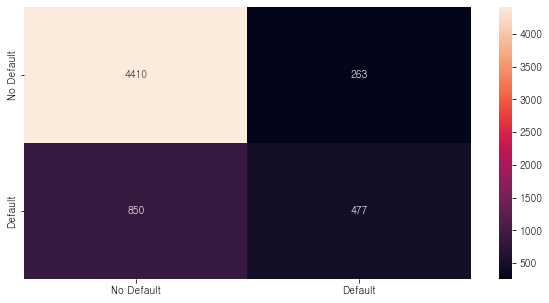

In [20]:
cm = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set_xticklabels(['No Default', 'Default'])
ax.set_yticklabels(['No Default', 'Default'])
plt.show()

- recall 을 높이기 위해 threshold 조정

In [21]:
y_proba = clf.predict_proba(X_test)
y_pred = y_proba[:, 1] > 0.3
y_pred

array([False, False, False, ..., False, False, False])

In [22]:
print("accuracy:", accuracy_score(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))

accuracy: 0.7813333333333333
precision: 0.5052410901467506
recall: 0.544837980406933


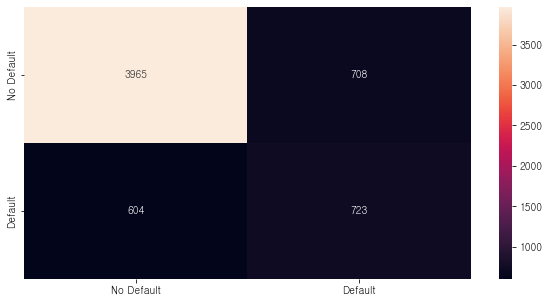

In [23]:
cm = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set_xticklabels(['No Default', 'Default'])
ax.set_yticklabels(['No Default', 'Default'])
plt.show()